### Learning algorithm
The algorithm used to solve the environment is maddpg (multi-agent deep deterministic policy gradient). It utilises a neural network for function proximator in order to find the optimal policy. The algorithm takes state as input and directly output the best action for that agent from that state.

### Hyperparameters
- n_agents = 2 # the number of agents in the algorithm
- state_dims = 24 # dimension of the state
- action_dims = 2 # the dimension of the action
- critic_hidden_layers = (256, 128) # the hidden layers of critic network
- actor_hidden_layers = (256, 128) # the hiddenlayers of actor network

### Architecture
Both the critic and actor use neural network for functio approximation. Bothe have 2 hidden layers, with 256 node and 128 node respectively. All hidden layers go through RELU activation function.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import sys
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [2]:
env = UnityEnvironment(file_name = 'Tennis.app')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

The next cell shows the performance of a random agent and the commands needed to interact with the Unity environment.

### 4. Solving the Environment

Next we implement Proximal Policy Optimization (PPO) to solve the environment.

When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

First, we import additional packages.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import sys
import time
import pandas as pd

In [5]:
%load_ext autoreload
%autoreload 2

For this environment, we'll be using DDPG and a couple of variations.

In [6]:
from models import DDPGModel, MADDPGModel, MAD3PGModel
from DDPG_agent import DDPGAgent
from MADDPG_agent import MADDPGAgent, MAD3PGAgent
from exploration_noise import OrnsteinUhlenbeckProcess as OUNoise, GaussianProcess

In [7]:
def train_multi_agent(env, multi_agent, n_episodes = 10000, n_agents = 2,
                      evaluation_window = 100, verbose = 100, solved_score = 1.0):
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    for i in range(n_agents):
        multi_agent.online_networks[i].to(device)
        multi_agent.target_networks[i].to(device)
    
    multi_agent.reset_current_step()
    
    scores = []
    
    for i in range(n_episodes):
        total_rewards = np.zeros(n_agents)
    
        env_info = env.reset(train_mode = True)[brain_name]
        state = env_info.vector_observations
        
        while True:
            action = multi_agent.action(state)
            
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            reward = np.array(env_info.rewards)
            done = np.array(env_info.local_done)
            
            total_rewards += reward
            
            multi_agent.update(state, action, reward, next_state, done)

            if np.any(done):
                break

            state = next_state
        
        scores.append(np.max(total_rewards))
        
        average_score = np.mean(scores[-min(evaluation_window, i + 1):])
        current_score = scores[-1]
        print('\rEpisode {} | Score: {:.2f} | Average Score: {:.2f}'.format(i + 1, current_score, average_score), end = '')
        sys.stdout.flush()
        if (i + 1) % verbose == 0:
            print('')
            
        if average_score > solved_score:
            print('\nEnvironment solved in {} episodes'.format(i + 1))
            break
    
    return scores

In [8]:
class ConstantScheduler():
    def __init__(self, value):
        self.value = value
        self.step = 0
        
    def __call__(self):
        self.step += 1
        value = self.value
        
        return value
        
    def reset(self):
        self.step = 0

class ExponentialScheduler():
    def __init__(self, start_value, end_value, rate):
        self.start_value = start_value
        self.end_value = end_value
        self.rate = rate
        self.value = start_value
        self.step = 0
        
        if end_value > start_value:
            assert rate > 1, 'Rate must be greater than one when the ending value is greater than the starting value'
            self.bound = min
        elif end_value < start_value:
            assert rate < 1, 'Rate must be less than one when the ending value is less than the starting value'
            self.bound = max
        else:
            raise ValueError('Start and end value cannot be the same')

    def __call__(self):
        self.step += 1
        value = self.value
        
        self.value = self.bound(self.value * self.rate, self.end_value)
        
        return value
        
    def reset(self):
        self.step = 0
        self.value = self.start_value

In [9]:
print('MADDPG Agents with Gaussian Noise')
maddpg_gn_scores = []

model_fn = lambda: MADDPGModel(2, 24, 2, critic_hidden_layers = (256, 128), actor_hidden_layers = (256, 128))

MADDPG_agents = MADDPGAgent(2, model_fn,
                            exploration_noise_fn = lambda: GaussianProcess((2, ), 
                                                                            ExponentialScheduler(3.0, .1, .99995)),
                            batch_size = 256, 
                            replay_start = 1000,
                            tau = 1e-3,
                            actor_learning_rate = 1e-4,
                            critic_learning_rate = 1e-3,
                            clip_gradients = 1.0,
                            share_weights = False)

scores = train_multi_agent(env, MADDPG_agents, n_episodes = 5000, n_agents = 2,
                            evaluation_window = 100, verbose = 100, solved_score = 0.5)
maddpg_gn_scores.append(scores)


MADDPG Agents with Gaussian Noise
Episode 100 | Score: 0.10 | Average Score: 0.02
Episode 200 | Score: 0.10 | Average Score: 0.01
Episode 300 | Score: 0.09 | Average Score: 0.01
Episode 400 | Score: 0.00 | Average Score: 0.01
Episode 500 | Score: 0.09 | Average Score: 0.01
Episode 600 | Score: 0.10 | Average Score: 0.02
Episode 700 | Score: 0.00 | Average Score: 0.02
Episode 800 | Score: 0.00 | Average Score: 0.02
Episode 900 | Score: 0.00 | Average Score: 0.02
Episode 1000 | Score: 0.00 | Average Score: 0.05
Episode 1100 | Score: 0.00 | Average Score: 0.05
Episode 1200 | Score: 0.00 | Average Score: 0.04
Episode 1300 | Score: 0.10 | Average Score: 0.05
Episode 1400 | Score: 0.09 | Average Score: 0.05
Episode 1500 | Score: 0.00 | Average Score: 0.04
Episode 1600 | Score: 0.09 | Average Score: 0.04
Episode 1700 | Score: 0.09 | Average Score: 0.04
Episode 1800 | Score: 0.00 | Average Score: 0.04
Episode 1900 | Score: 0.10 | Average Score: 0.13
Episode 2000 | Score: 0.10 | Average Score: 

In [13]:
torch.save(MADDPG_agents.online_networks[0].state_dict(), 'agent_1_online_networks.pt')
torch.save(MADDPG_agents.online_networks[1].state_dict(), 'agent_2_online_networks.pt')
torch.save(MADDPG_agents.target_networks[0].state_dict(), 'agent_1_target_networks.pt')
torch.save(MADDPG_agents.target_networks[1].state_dict(), 'agent_2_target_networks.pt')

Text(0, 0.5, 'Score')

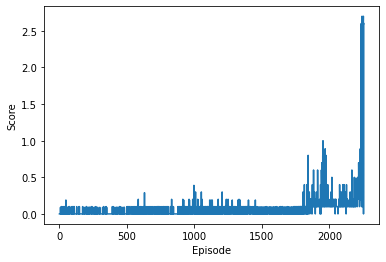

In [15]:
plt.plot(scores)
plt.xlabel('Episode')
plt.ylabel('Score')

### Future work
1. Hyperparameters tuning is not done in this notebook. Potentially, we can fine tune the Hyperparameters to optimise the training result.
2. Try other multi-agent reinforcement learnining algorithms. The base agent is ddpg in this notebook. We can try other agents such as TD3.  